### Table of content

* [1. Introduction](#introduction)
* [2. Import required packages](#import)
* [3. Load the data](#load)
* [4. Data wrangling](#wrangle)
    * [4.1. Data wrangling of the users' login history data](#df2)
    * [4.2. Data wrangling of the users data](#df)
    * [4.3. Missing data in _last session creation time ](#last)
    * [4.4. Missing data in _invited_by_user_id_ ](#invite)
    * [4.5. Find adopted users](#find)
    * [4.6. Is data imbalanced?](#imb)
* [5. Exploratory data analysis](#eda)
    * [5.1. Exploring effects of several factor on user adoption](#effect)
* [6. Preprocessing ](#process)
    * [6.1. Define features and target](#define)
    * [6.2. Apply One Hot Encoder to change categorical columns to numerical columns](#oneHot)
    * [6.3. Split the data](#split)
* [7. Model training](#model)
    * [7.1. Make pipeline and hyperparameter tune with GridSearchCV](#pipe)
    * [7.2. Train random forest classifier with best hyperparameter](#best)
    * [7.3. Visualize the result of classification](#vis)
    * [7.4. Feature importance assessment](#fi)
* [8. Summary](#summary)

## 1. Introduction <a class='anchor' id='introduction'></a>

This notebook is about an online platform and the ultimate objective is to identify which  factors  predict  future  user adoption. An adoppted user is defined as a person who logged in equal or more than 3 times in any 7-day window. There are two files available: one is the history of users' logins and the second one contains information about the users. These information include:
1. name:  the  user's  name
2. object_id:   the  user's  id
3. email:  email  address
4. creation_source:   how  their  account  was  created.  
5. creation_time:  when  they  created  their  account
6. last_session_creation_time:   unix  timestamp  of  last  login
7. opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails
8. enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip
9. org_id:   the  organization  (group  of  users)  they  belong  to
10. invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).

### 2. Import required packages <a class='anchor' id='import'><a/>

I start by importing required packages.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image  
import pydotplus

from datetime import datetime, timedelta
import datetime

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.compose import make_column_selector as selector
from sklearn import tree, metrics

### 3. Load data files <a class='anchor' id='load' ><a/>

There are two files that we need. One is users' data and the other is the users' login history. I use pandas to open these two files and save as df and df2.

In [40]:
# Opening user data file and check the columns, shape and etc

df = pd.read_csv('takehome_users.csv')
print(df.shape)
df.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [41]:
# Opening user engagement data file and check the columns, shape and etc

df2 = pd.read_csv('takehome_user_engagement.csv')
print(df2.shape)
df2.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


For the second data file, users' login history, which is a time series, I need to set the index to the time data, as well as changing it to datetime format.

In [42]:
# Change the time stamp to datetime and set the columns the index 

df2 = df2.set_index(pd.to_datetime(df2['time_stamp']))[['user_id', 'visited']]
df2.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


## 4. Data wrangling <a class='anchor' id='wrangle'><a/>

I satrt data wrangling by the second dataframe, df2, which has a smaller number of columns. I check the data type and if there is any missing datapoints.

### 4.1. Data wrangling of the users' login history data <a class='anchor' id='df2'><a/>

In [43]:
# Checke df2 data type
df2.dtypes

user_id    int64
visited    int64
dtype: object

In [44]:
# Check missing data in df2
missing1 = df2.isnull().sum()
missing2 = 100*df2.isnull().mean()
missing = pd.concat([missing1, missing2], axis=1)
missing.columns = ['count', '%']
missing

,count,%
user_id,0,0.0
visited,0,0.0


There is no missing data in the users' login history file and data columns are integer. 

### 4.2. Data wrangling of the users data <a class='anchor' id='df'><a/>

I use describe() to get an understanding of the data, then I check the data type and if there is any missing datapoints.

In [45]:
df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [46]:
# Check the data type
df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [47]:
# Check if there is any missing dta

missing1 = df.isnull().sum()
missing2 = 100*df.isnull().mean()
missing = pd.concat([missing1, missing2], axis=1)
missing.columns = ['count', '%']
missing

,count,%
object_id,0,0.000
creation_time,0,0.000
name,0,0.000
email,0,0.000
creation_source,0,0.000
last_session_creation_time,3177,26.475
opted_in_to_mailing_list,0,0.000
enabled_for_marketing_drip,0,0.000
org_id,0,0.000
invited_by_user_id,5583,46.525


As expected names and emails are object type. Last login is float because it is Unix time stamp and it needs to be converted to datetime. Creation time also needs to change to datetime. Furthermore, there are 5583 missing points in _invited_by_user_id_ column. I need to find if these are  missing, or they are not available because, the person is not invited. 



In [48]:
# Change the 'last session' Unix time stamp to datetime object
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'],unit='s') 

In [49]:
# Change the creation time stamp to datetime object
df['creation_time'] =pd.to_datetime(df['creation_time'])

I then check if 'last session' is after the creation date to ensure there is not any error in our data.

In [50]:
# Check if 'last session' is after the creation date to ensure data quality

mask = df['last_session_creation_time'] - df['creation_time']< timedelta(days=0)
mask.value_counts()

False    12000
dtype: int64

For the purpose of modeling, the duration of time a user uses the platform is more meaningful than the creation day or the day of last login. Therefore, I define a new parameter called _Active_window_ which is the difference between these two times.

In [51]:
# define membership length

df['Active_window'] = (df['last_session_creation_time'] - df['creation_time'])/timedelta(days=1)

### 4.3. Missing data in _last session creation time_ <a class='anchor' id='last'><a/>

26% of last login data in missing, which has lead to same amount of missing points in the _Membership length_ parameter. To explore more, there is a chance that some users have never logged in their account after the first time they signed up, and because of that these value is not available for these users. To investigate more, I check if there is any user with _Membership length_ of zero. If there are users whoes their _creation date_ and _last login date_ are the same, the I conclude these missing _last login date_ are missing and cannot be 0. It will help with deciding how to impute these missing values for the purpos of modeling 

In [52]:
# checking users with same day creation and last login date, which is equal to zero membership length

df.loc[df['Active_window']==0, 'object_id'].count()

3027

There are 3027 users with zero _Active window_, consequently, I cannot fill missing points in _Active window_ with zeros. I need to have another stategy. I should either drop them or impute them. Therefore, I will look at the distribution of the membership length to get a better idea.

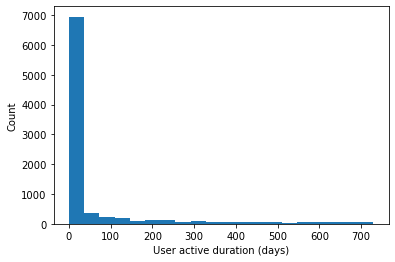

In [56]:
fig, ax=plt.subplots()
ax.hist(df['Active_window'], bins=20)
ax.set_xlabel('User active duration (days)')
ax.set_ylabel('Count')
plt.show()

 The majority of users have used the platform shoerter than 100 days. According to the plot, using a median to impute _Active window_ is reasonable. I will do the imputation during model training.

### 4.4. Missing data in _invited_by_user_id_ <a class='anchor' id='invite'><a/>

The column _invited_by_user_id_ has 46% missing values. I sort this column to see if nan actually means that the user was not invited. As shown below, there is no 0, I conclude that Nan means the user is not invited. For the perpuse of modelling I will fill Nan values with zero. 

In [57]:
df['invited_by_user_id'].sort_values()

11999        0.0
5162         0.0
10021        0.0
10024        0.0
5157         0.0
          ...   
8056     11999.0
9700     11999.0
10880    11999.0
5190     11999.0
2548     11999.0
Name: invited_by_user_id, Length: 12000, dtype: float64

In [58]:
# Fill the nan values with zero
df['invited_by_user_id'] = df['invited_by_user_id'].fillna(0)

For the purpose of modeling, it does not matter what is the id_number of a user who invites another person, what matters is if the user has been invited or not. Therefore I define a new column called _if invited_ to show it. If a person is invited then _if invited_ value will be 1 and in the case the person is not invited, it will be 0. 

In [59]:
# Define a new column to show if a user has been invited or not
df['if_invited'] = 0
df.loc[df['invited_by_user_id']!=0, 'if_invited'] = 1

### 4.5. Find adopted users <a class='anchor' id='find'>

I will define a function and check each user to find out if he/she has logged in on at least 3 days in a 7-day window. For each user, I first find the days the user logged in, and then I check the time difference between the first and the third login, if it is smaller or equal to 7, then the user is an adopted user.

In [60]:
def royal_user(user_id):
    df = df2.loc[df2['user_id']==user_id]
    df = df.resample('D').mean().dropna()  # Finding the days that the user has logged in and dropping the non-log days
# loop over the active days and see if the time difference between the third login and first is smaller or equal to 7    
    for i in range(len(df) - 2):
        if df.index[i + 2] - df.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            return 1
    return 0       


In [61]:
# Check if my function works correctly for user_id=2: According to the user engagement file this person is an adopted user

user2 = df2.loc[df2['user_id']==2]
user2 = user2.resample('D').mean().dropna()
user2.resample('W')['visited'].sum()
print(user2.resample('W')['visited'].sum())
print(royal_user(2))

time_stamp
2013-11-17    1.0
2013-11-24    0.0
2013-12-01    1.0
2013-12-08    0.0
2013-12-15    1.0
2013-12-22    0.0
2013-12-29    1.0
2014-01-05    1.0
2014-01-12    1.0
2014-01-19    0.0
2014-01-26    0.0
2014-02-02    0.0
2014-02-09    3.0
2014-02-16    2.0
2014-02-23    0.0
2014-03-02    0.0
2014-03-09    1.0
2014-03-16    1.0
2014-03-23    0.0
2014-03-30    0.0
2014-04-06    1.0
Freq: W-SUN, Name: visited, dtype: float64
1


Now that I have a working function, I create a column, 'if_adopted' in the data frame. If a user is an adopted user, this value is 1 and if not this value is 0. 

In [62]:
df['if_adopted'] = df['object_id'].apply(royal_user)
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active_window,if_invited,if_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,1,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,1,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5.0,1,0


## 4.6. Is data imbalanced? <a class='anchor' id='imb'><a/>

A data set is called imbalanced, if the minority class makes a small percentage of the data set.

If the minority class (in our case the defaulted loans) makes 20 to 40% of a data set, then it is mildly imbalance. if the minority class is 1 to 20%, then the dataset is moderately imbalanced and if minority class is < 1% of data set, the data is extremely imbalanced.

To find out if our data set is imbalanced or not, we will look at waht percentag of users in the data frame are adopted users.

In [63]:
df['if_adopted'].value_counts()/len(df)

0    0.862
1    0.138
Name: if_adopted, dtype: float64

Adopted users count for 14% of the data set. Therefore, our data is moderately imbalanced, which may or may not be a problem. It is suggested to model with the true distribution and if the result is not fine, apply techncis such as undersampling to deal with the imbalance.

## 5. Exploratory data analysis <a class='anchor' id='eda'><a/>

### 5.1. Exploring effects of several factor on user adoption <a class='anchor' id='effect'><a/>

Next I will plot bar charts to show the effect of various features on the adoption of users. These features are:

1. Creation source.
2. If a user is in the mailing list or not.
3. If a user is in the marketing list.
4. If a usr is invited or not.

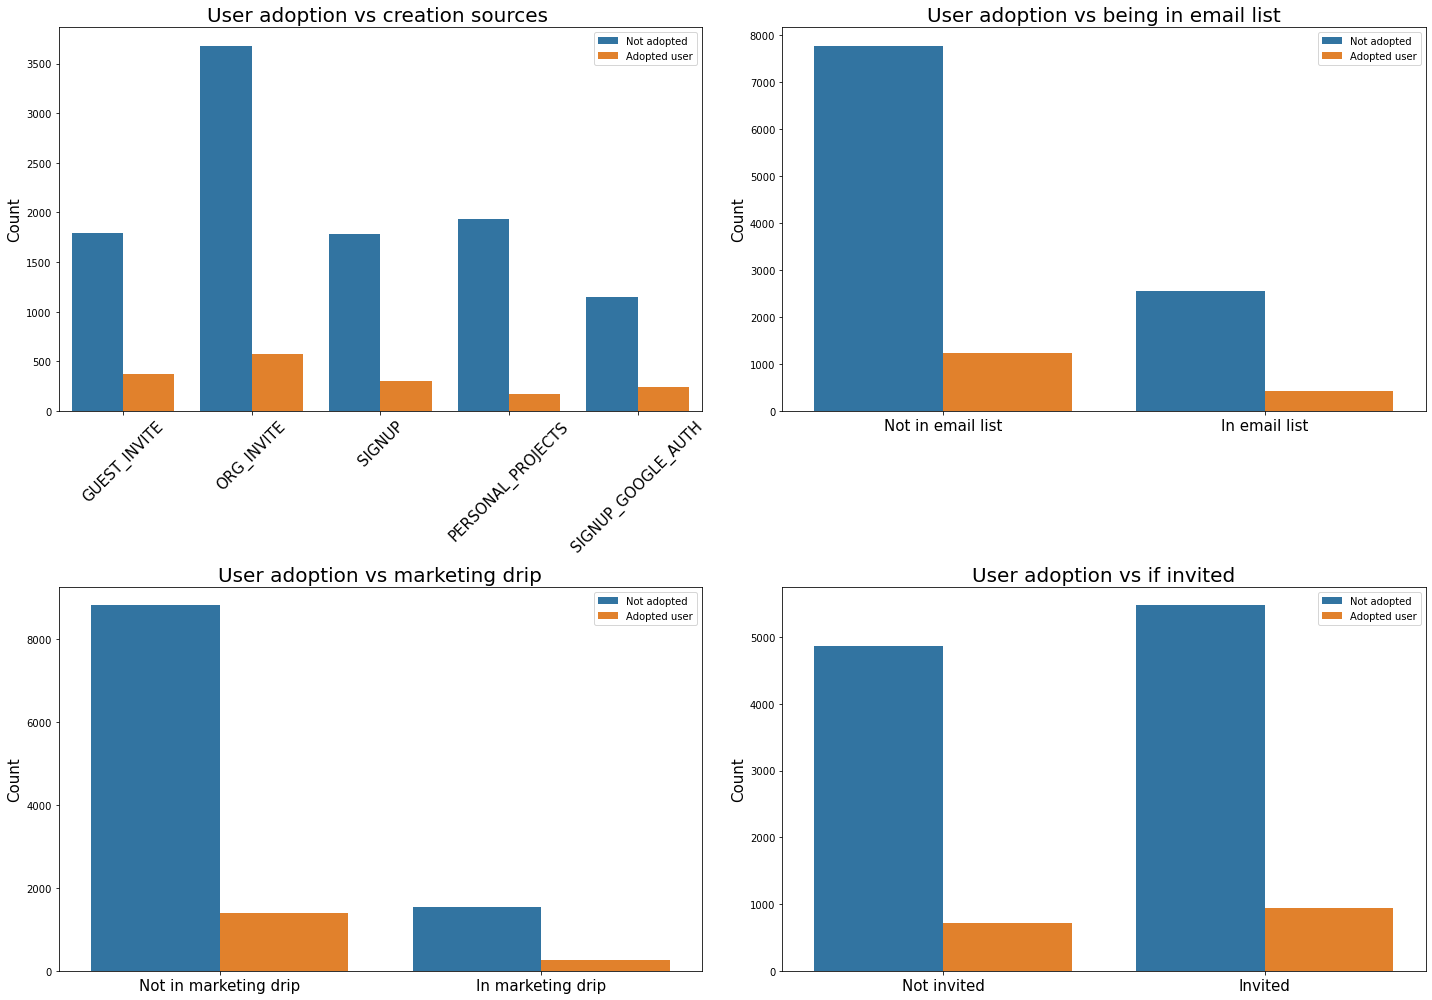

In [64]:
fig, [(axes0, axes1), (axes2, axes3)] = plt.subplots(nrows = 2, ncols = 2, figsize=(20,14))


sns.countplot(x="creation_source", hue='if_adopted', data=df, ax=axes0)
sns.countplot(x="opted_in_to_mailing_list", hue='if_adopted', data=df, ax=axes1)
sns.countplot(x="enabled_for_marketing_drip", hue='if_adopted', data=df, ax=axes2)
sns.countplot(x="if_invited", hue='if_adopted', data=df, ax=axes3)

axes0.legend(['Not adopted','Adopted user'])
axes0.set(xlabel=None)
axes0.set_xticklabels(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS','SIGNUP_GOOGLE_AUTH'], rotation=45, fontsize=15)
axes0.set_ylabel('Count', fontsize=15)
axes0.set_title("User adoption vs creation sources ", fontsize=20)

axes1.legend(['Not adopted','Adopted user'])
axes1.set(xlabel=None)
axes1.set_xticklabels(['Not in email list', 'In email list'], fontsize=15)
axes1.set_ylabel('Count', fontsize=15)
axes1.set_title('User adoption vs being in email list', fontsize=20)

axes2.legend(['Not adopted','Adopted user'])
axes2.set(xlabel=None)
axes2.set_xticklabels(['Not in marketing drip', 'In marketing drip'], fontsize=15)
axes2.set_ylabel('Count', fontsize=15)
axes2.set_title('User adoption vs marketing drip', fontsize=20)

axes3.legend(['Not adopted','Adopted user'])
axes3.set(xlabel=None)
axes3.set_xticklabels(['Not invited', 'Invited'], fontsize=15)
axes3.set_ylabel('Count', fontsize=15)
axes3.set_title("User adoption vs if invited", fontsize=20)

plt.tight_layout()
plt.show()    

Visually inspecting, no difference is visible among different groups. I then plot a stacked histogram of the _adoption_ vs _Active window_.

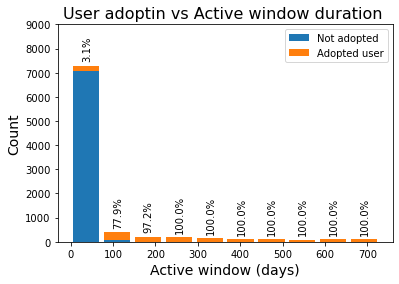

In [113]:
s1 = pd.DataFrame({'Adopted': df.loc[df['if_adopted']==0, 'Active_window'], 'Not adopted': df.loc[df['if_adopted']==1, 'Active_window']})
fig, ax = plt.subplots()

n=10
ax.hist(s1, stacked=True, bins=n, rwidth=0.85)

ax.legend(['Not adopted', 'Adopted user'])
ax.set_xlabel('Active window (days)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('User adoptin vs Active window duration ', fontsize=16)
ax.set_ylim(0,9000)

for i in range(0,n,1):

    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + 25
    Y1 = p[i].get_height()
    Y2 = p[i+n].get_height()
    y = Y2 + Y1+250 
    a = Y2/(Y2 + Y1)     
    ax.text(x, y, str(np.round(a*100,1)) + '%', rotation=90)
plt.show()

It is clear from the plot that, the longer a user uses the platform, there is a higher chance for the user to become an adopted user. 

## 6. Preprocessing <a class='anchor' id='process'></a>

### 6.1. Define features and target <a class='anchor' id='define'><a/>

To get the data ready for model training, these are the steps that I will take:

1. First I define the features that I will include in the model and I will also determine the target column. 
2. I will select the categorical features and will apply One Hot Encoder to turn them into numerical columns.
3. I will split the data into training and testing tests.

The target column in our data frame is _if_adopted_. There are several features that I will drop from model training. These features are 'object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 'org_id', 'invited_by_user_id'. Name and email, org_id and obj_id are personal information and are not needed. 'creation_time' and 'last_session_creation_time' are two columns that I used to generate _Membership length_, which is a more reasonable measure to include in modeling. I also added a column to show if a user has been invited or not. Therefore I can drop 'invited_by_user_id' column.


In [114]:
# Defining X and y

y = df['if_adopted']
drop_list=['if_adopted', 'object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 'org_id', 'invited_by_user_id']
X = df.drop(columns=drop_list, axis=1)

In [115]:
# Check X data type.
X.dtypes

creation_source                object
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
Active_window                 float64
if_invited                      int64
dtype: object

### 6.2. Apply One Hot Encoder to change categorical columns to numerical columns <a class='anchor' id='oneHot'></a>

There is a categorical column _Creation source_ and it needs to turn into numerical columns. I use One Hot Encoder.

In [116]:
# Choosing the categorical columns
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# creating instance of one-hot-encoder

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)

### 6.3. Split the data <a class='anchor' id='split'><a/>
    
To ensure that I have non-exposed data to test my model, I split my data into train and test. I do all modeling on training set and I will apply the result on test set.

In [117]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

## 7. Model training <a class='anchor' id='model'><a/>


I will use random forest classifier.

These are the steps that I will follow.


1. Make a pipeline, that includes the model, imputing and scaling steps.

2. Using cross validation to train a general model and look at the scores.

3. Grid search to find the hyperparameters

4. training the model with the best hyperparameters

5. Model score and feature importance assessment

### 7.1. Make pipeline and hyperparameter tune with GridSearchCV <a class='anchor' id='pipe'><a/>

I use make_pipeline to create a pipe which includes imputing missing data in _Active window_, then sacle the data and finally apply Random Forest. I use cross validation with 6 folds to avoid overfitting.

I use SimpleImputer to impute the data and I use median values of _Active window_ to fill the missing values.

For scaling, I use MinMaxScaler. This scaler allocate 1 to the highest value and 0 to he smallest value and scale the rest of values accordingly. Given that there are categorical column such as creation source, which are presented by zeros and ones, I do not want these columns be affected by scaling. MinMaxScaler insures these columns will be intact.

There are several parameters in tuning a random forest classifier. Given the limitation in the computational power, I choose three of the important ones and include them in the grid search.  

Furthermore given that our data is imbalanced, I use f1 score to evalute model performance. f1 score is a harmonic mean of precision and recall and is better metric for imbalance data compared with accuracy. 

In [118]:
# Make pipeline
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    MinMaxScaler(), 
    RandomForestClassifier(random_state=47)
)

cv_results = cross_validate(pipe, X_train, y_train, cv=6, scoring='f1')
cv_scores = cv_results['test_score']

print(cv_scores)
print(cv_scores.mean(), cv_scores.std())

[0.86684073 0.87792208 0.88297872 0.89405685 0.84102564 0.85063291]
0.8689094887266825 0.018381973886920477


In [119]:
# Define parameters for grid search
param_grid = { 
    'minmaxscaler': [MinMaxScaler(), None],
    'randomforestclassifier__n_estimators': [12, 20, 50, 100, 200, 400, 600, 1000],
    'randomforestclassifier__max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'randomforestclassifier__criterion' :['gini', 'entropy']
}

# perform Grid search on training data with 5 fold cross validation

rf_grid_cv  = GridSearchCV(pipe, param_grid = param_grid, scoring='f1', cv = 6, n_jobs = -1)
rf_grid_cv.fit(X_train, y_train)

# Best hyperparameters
rf_grid_cv.best_params_

{'minmaxscaler': MinMaxScaler(),
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 3,
 'randomforestclassifier__n_estimators': 600}

###  7.2.  Random forest classifier with best hyperparameter <a class='anchor' id='best'><a/>

Using the tuned hyperparameters I found by doing the grid search, I train random forest on training data while doing cross validation. Compared with the default first training, grid search has imporved the result from 86% to 90%

In [120]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=6, scoring='f1')
rf_best_scores = rf_best_cv_results['test_score']
print(rf_best_scores)
np.mean(rf_best_scores), np.std(rf_best_scores)

[0.89528796 0.91578947 0.91935484 0.91666667 0.8976378  0.8987013 ]


(0.9072396718587713, 0.010138112264217127)

###  7.4. Feature importance assessment <a class='anchor' id='fi'><a/>

Using the grid search parameters, I check the most important features in the random forest classifier and plot them in a bar chart.

In [121]:
model_features = pd.DataFrame(rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_)
model_features.index = X.columns
model_features.columns=['Importance']
model_features.sort_values(by='Importance', ascending=False)

,Importance
Active_window,0.940285
creation_source_PERSONAL_PROJECTS,0.029430
creation_source_GUEST_INVITE,0.010726
creation_source_SIGNUP_GOOGLE_AUTH,0.005254
opted_in_to_mailing_list,0.004322
if_invited,0.003373
enabled_for_marketing_drip,0.002880
creation_source_ORG_INVITE,0.002045
creation_source_SIGNUP,0.001684


Text(0, 0.5, 'Coefficient')

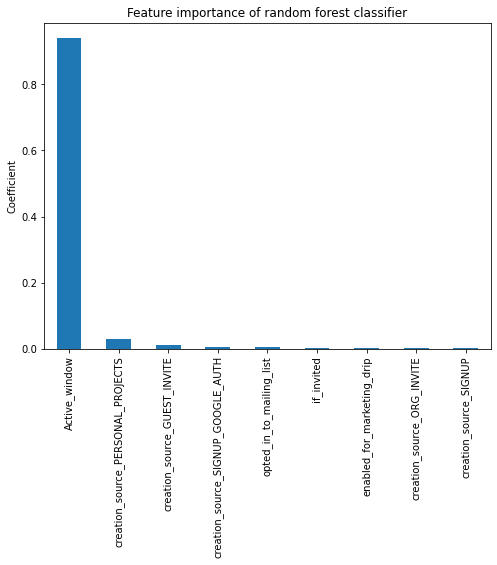

In [122]:
fig, ax=plt.subplots()
model_features.sort_values(by='Importance', ascending=False).iloc[:, model_features.columns.get_loc('Importance')].plot(kind='bar', figsize=(8,6))
ax.set_title('Feature importance of random forest classifier')
ax.set_ylabel('Coefficient')


As seen in the plot _Active window_, which is the diffirence between the time a user creates its account and the last time he/she login, is the most influential parameter in determining if a user will be an adopted user or not. This finding is align with exploratory analysis that was done earlier.

## Apply the model to the test data

In [123]:
y_pred = rf_grid_cv.best_estimator_.predict(X_test)

0.924543807155801


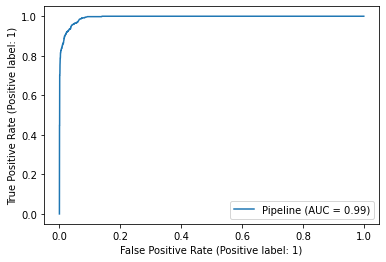

In [124]:
print(roc_auc_score(y_test, y_pred))
metrics.plot_roc_curve(rf_grid_cv.best_estimator_, X_test, y_test)

In [125]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3112
           1       0.92      0.86      0.89       488

    accuracy                           0.97      3600
   macro avg       0.95      0.92      0.94      3600
weighted avg       0.97      0.97      0.97      3600



## 8. Summary <a class='anchor' id='summary'><a/>

In this notebook, I generated a predictive model to predict future user adoptation. Two data files were available; one a history of users' login and a second one which includes users' info such as name and email.

These are the steps I did to clean, explore and analyze the data:

1. Addressed the missing data points. 
2. Generated a new feature to estimate the time period a user has been on the platform
3. Defined a function and found adopted users based on the given definition.
3. Checked if the data is imbalanced
4. Explored the data and ploted several features to explore effects of various features on adoption
5. Changed categorical data to numerical columns
6. Splited the data
7. Made a pipeline and trained a random forest classifier
8. Performed grid search
9. Studied feature importance.
10. Applied the model to the testing data set and evaluate its performance
 

What I found can be summarized as follow:

1. Only 13% of users are adopted users. Therefore, our data set is imbalanced.
2. The majority of users use the platform shorter than 100 days.
3. Plotting user adoption versus different factors did not show any specific correlation with being in the mailing list or the marketing list. However, the _Active window_, the time length a user has been using the platforme was effective.
4. The random forest classifier modeled with .89 f score and the area under the ROC curve was 0.93. So the model performs pretty well in predicting user adoption
5. _Active window_, which is the diffirence between the time a user creates its account and the last time he/she login, is the most influential parameter in determining if a user will be an adopted user or not. Creation source was the second influential parameter followed by if the user is in the mailing list or not.

What can be done better?

1. I did not look at the emails and if email domains used by users have any influence on user adoption or not.
2. The data is imbalanced and while the model performed pretty well, it can still be improved by addressing the imbalanced data.
3. There is computational restrictions. With more computational power,  a bigger grid with more parameters can be searched for hyperparameter tunning.   
4. A learning curve can be provided to show if further data is needed or not. However, given the good performance of the model, we can conclude that we have enough data.

5. Other models such as logistic regression can be applied to the data to compare the result with random forest and improve the classification.




